In [1]:


import torch

from torch.utils.data import Dataset, DataLoader



from torchvision import transforms as T, utils

import matplotlib.pyplot as plt
from PIL import Image




from denoising_diffusion_pytorch.version import __version__

#ab diffusion related imports
from AB_diffusion.user_hints import RandomHintGenerator, get_color_hints 
from AB_diffusion.color_handling import de_normalize_lab, normalize_lab,plotMinMax
from AB_diffusion.ab_denoising_diffusion_pytorch import ABUnet, ABGaussianDiffusion
from AB_diffusion.ab_trainer import ABDataset
from IPython.utils import io as iol
from skimage import io
from kornia.color import rgb_to_lab, lab_to_rgb
from datasets import load_from_disk,load_dataset
#from ab_classifier_free_guidance import *


import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import random
import glob
import mplcursors
import ipywidgets as widgets
from IPython.display import display
import torchvision.transforms as transforms




In [2]:
model_folder = "./models"
model_name = "v_pred_256_1000_cosine_13k_fine_tune.pt"
device = torch.device(6 if torch.cuda.is_available() else "cpu")
print("Selected GPU:", torch.cuda.get_device_name(device))
#check wicj gpu is selected
torch.cuda.set_device(device)

Selected GPU: A100-SXM4-80GB


In [3]:
unet = ABUnet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    out_dim = 2,
    channels=5
    )

def load(model_name):
    print(str(model_folder  + f'/{model_name}'))
    data = torch.load(str(model_folder  + f'/{model_name}'), map_location=device)
    return data

diffusion_model = ABGaussianDiffusion(
        unet,
        image_size = 256,
        timesteps = 1000,
        objective = 'pred_v',
        beta_schedule = 'cosine',
        min_snr_loss_weight = False,
)
with iol.capture_output() as captured:
    loaded_data = load(model_name)
    diffusion_model.load_state_dict(loaded_data['model'])
    diffusion_model.to(device)
#make it not print from this cell



sampling timesteps 1000
timesteps 1000


In [14]:
#test_folder = "./data/sem images/val"
#
dataset_test = load_dataset("imagenet-1k",split="validation")
#image_dir_val = "./data/sem images/val"


#dataset_test = load_dataset("imagefolder", data_dir=image_dir_val)["train"]
dataset = ABDataset(dataset_test,image_size=64)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, pin_memory = True,num_workers=100//6)
#



Using custom data configuration default
Reusing dataset imagenet-1k (/Home/siv32/eve036/.cache/huggingface/datasets/imagenet-1k/default/1.0.0/a1e9bfc56c3a7350165007d1176b15e9128fcaf9ab972147840529aed3ae52bc)


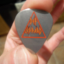

In [15]:
#img = Image.open("./test_img.png")
##convert to torch tensor
#img
imgL, imgAB = next(iter(dataloader))

#cat them together, convert to rgb and display
imgLAB = torch.cat((imgL,imgAB),dim=1)
imgRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(imgLAB).squeeze(0).detach().cpu()
            )
        )


imgRGB


In [69]:
import skimage.color as skcolor

import kornia.color as kacolor
from ipyevents import Event
import io


class ModelWrapper:
    def __init__(self, model, device="cpu"):
        self.model = model
        self.device = device

    def colorize(self, input_image_L_tensor, user_hints_tensor, output_count):
        conditioning = torch.cat([input_image_L_tensor, user_hints_tensor], dim=1)
        conditioning = conditioning.repeat(output_count, 1, 1, 1)
        conditioning = normalize_lab(conditioning)
        output_AB = self.model.sample(conditioning.to(self.device))

        self.colorization_LAB_tensor = de_normalize_lab(torch.cat([conditioning[:, :1, :, :], output_AB.to("cpu")], dim=1))

    
class ImageProcessor:
    def __init__(self, image):
        self.image = image.copy()
        self.input_image_LAB_tensor = self.convert_to_lab_tensor(self.image.copy())
        self.input_image_L_tensor = self.input_image_LAB_tensor[:, :1, :, :]
        self.user_hints_tensor = torch.zeros_like(self.input_image_LAB_tensor[:, 1:, :, :])
        
        self.point_color_conversions = PointColorConversions()

    def convert_to_lab_tensor(self, image):
        return kacolor.rgb_to_lab(transforms.ToTensor()(image).unsqueeze(0))

    def lab_tensor_to_image(self, lab_tensor):
        output_image = transforms.ToPILImage()(kacolor.lab_to_rgb (lab_tensor.squeeze(0).detach().cpu()))
        return output_image

    def apply_hints_to_image(self, x, y, color, sampling_size):
        # Your existing code here, modified to work with the new structure.
        # The code should update self.user_hints_tensor based on the x, y, color, and sampling_size parameters.    
        color_lab = self.point_color_conversions.hex_to_lab(color)
        print(color)
        print(color_lab)
        print(sampling_size)
        print(x)
        print(y)

    
        half_sampling = sampling_size // 2

        x_start = max(0, x - half_sampling)
        y_start = max(0, y - half_sampling)
        x_end = min(self.image.width, x + half_sampling)
        y_end = min(self.image.height, y + half_sampling)
    
        # Create blank image tensor
        # Apply color to image tensor
        self.user_hints_tensor[:,0,y_start:y_end,x_start:x_end] = color_lab[1]
        self.user_hints_tensor[:,1,y_start:y_end,x_start:x_end] = color_lab[2]


    def clear_inputs(self):
        self.user_hints_tensor = torch.zeros_like(self.user_hints_tensor)

    def get_input_tensors(self):
        return self.input_image_L_tensor, self.user_hints_tensor

    def get_input_image(self):
        return self.image

    def get_hinted_image(self):
        temp_lab = torch.cat([self.input_image_L_tensor, self.user_hints_tensor], dim=1)
        return self.lab_tensor_to_image(temp_lab)

class WidgetManager:
    def __init__(self, image_processor, model_wrapper):
        self.image_processor = image_processor
        self.model_wrapper = model_wrapper
        
        self.colorized_images_bytes = None

        self.image_widget = self.create_image_widget()
        self.main_colorized_image_widget = self.create_main_colorized_image_widget()
        self.colorized_image_grid = self.create_colorized_image_grid()
        self.color_picker = self.create_color_picker()
        self.hint_size_slider = self.create_hint_size_slider()
        self.output_count_slider = self.create_output_count_slider()
        self.colorize_button = self.create_colorize_button()
        self.clear_button = self.create_clear_button()
        self.export_button = self.create_export_button()
    
    

    def display(self):

        # Create labels
        input_image_label = widgets.Label('Input Image')
        colorization_label = widgets.Label('Colorization')

        # Create a layout for original and colorized images
        input_image_box = widgets.VBox([input_image_label, self.image_widget])

        # Put the colorized image grid in a VBox with an empty Label to push it to the bottom
        colorized_image_grid_box = widgets.VBox([widgets.Label('Click to select'), self.colorized_image_grid])
    
        # Create a box for the main colorized image and the grid
        colorization_box = widgets.HBox([widgets.VBox([colorization_label, self.main_colorized_image_widget]), colorized_image_grid_box], box_style='info')

        image_layout = widgets.HBox([
            input_image_box,
            colorization_box, 
        ])

        # Create a layout for the controls
        control_layout = widgets.VBox([
            self.color_picker, 
            self.hint_size_slider, 
            self.output_count_slider, 
            self.colorize_button,
            self.clear_button,
            self.export_button,
        ])

        # Combine the layouts
        layout = widgets.VBox([image_layout,control_layout])

        # Display the layout
        display(layout)
    def create_colorized_image_grid(self):
        colorized_image_grid = widgets.GridBox([], layout=widgets.Layout(grid_template_columns="repeat(3, 100px)"),align_items='center')
        return colorized_image_grid

    def create_main_colorized_image_widget(self):
        main_colorized_image_widget = widgets.Image(format='png',description='Colorized Image')
        main_colorized_image_widget.layout = widgets.Layout(object_fit='contain', height='auto', width='300px')
        return main_colorized_image_widget
    
    def create_image_widget(self):
        
        image_widget = widgets.Image(format='png',description='Input Image')

        image_widget.layout = widgets.Layout(object_fit='contain', height='auto', width='300px')
        # Set the initial image data
        image_widget.value = self.to_bytes(self.image_processor.get_input_image())

        event = Event(source=image_widget, watched_events=['click'])
        event.on_dom_event(self.on_image_click)

        return image_widget
    
    def create_color_picker(self):
        color_picker = widgets.ColorPicker(value='#000000', description='Color:')
        return color_picker
    def create_hint_size_slider(self):
        hint_size_slider = widgets.IntSlider(value=4, min=2, max=10, description='Hint Size:')
        return hint_size_slider
    def create_output_count_slider(self):
        output_count_slider = widgets.IntSlider(value=1, min=1, max=10, description='Output Count:')
        return output_count_slider
    
    def create_colorize_button(self):
        colorize_button = widgets.Button(description='Colorize!')
        colorize_button.on_click(self.on_colorize_button_click)
        return colorize_button
    def create_clear_button(self):
        clear_button = widgets.Button(description='Clear')
        clear_button.on_click(self.on_clear_button_click)
        return clear_button
    
    def create_export_button(self):
        self.export_filename_text = widgets.Text(value='output.png', description='Filename:')
        export_button = widgets.Button(description='Export')
        export_button.on_click(self.on_export_button_click)
        return widgets.VBox([self.export_filename_text, export_button])

    def on_export_button_click(self, _):
        # Get the image data from the widget
        image_data = self.main_colorized_image_widget.value

        # Check if image_data is not empty
        if not image_data:
            print("No image data to export.")
            return

        # Convert the image data to a PIL Image
        try:
            image = Image.open(io.BytesIO(image_data))
        except IOError:
            print("Cannot convert image data to PIL Image. The data may not be in a valid image format.")
            return

        # Save the image with the filename from the text widget
        filename = self.export_filename_text.value
        try:
            image.save(filename)
            print(f"Image exported as {filename}.")
        except IOError:
            print(f"Cannot save image as {filename}.")

    def create_colorized_image_widget(self, image_bytes):
        img_widget = widgets.Image(value=image_bytes, format='png')
        img_widget.layout = widgets.Layout(object_fit='contain', height='auto', width='100px')
    
        def on_click(event):
            self.on_additional_colorization_click(image_bytes)

        event_handler = Event(source=img_widget, watched_events=['click'])
        event_handler.on_dom_event(on_click)

        return img_widget

    def on_clear_button_click(self, _):
        self.image_processor.clear_inputs()
        self.image_widget.value = self.to_bytes(self.image_processor.get_hinted_image())
    


    def on_colorize_button_click(self, _):
        input_image_L_tensor, user_hints_tensor = self.image_processor.get_input_tensors()
        output_count = self.output_count_slider.value
    
        self.model_wrapper.colorize(input_image_L_tensor, user_hints_tensor, output_count)
    
        model_output_LAB_tensor = self.model_wrapper.colorization_LAB_tensor
        # Convert the colorized images from tensors to PIL images, and then to bytes
        self.colorized_images_bytes = [self.to_bytes(self.image_processor.lab_tensor_to_image(img)) for img in model_output_LAB_tensor]
    
        # Update the main colorized image widget with the first colorized image
        self.main_colorized_image_widget.value = self.colorized_images_bytes[0]
    
        # Create an image widget for each additional colorization
        additional_colorizations_widgets = []

        if output_count > 1:
            for img_bytes in self.colorized_images_bytes:
                img_widget = self.create_colorized_image_widget(img_bytes)
                additional_colorizations_widgets.append(img_widget)
    
        # Update the grid with the additional colorizations
        self.colorized_image_grid.children = additional_colorizations_widgets
    
    def on_additional_colorization_click(self, image_bytes):
        # Update the main colorized image widget with the clicked image
        self.main_colorized_image_widget.value = image_bytes
    
    def on_image_click(self, event):
        x = event['dataX']
        y = event['dataY']
        color = self.color_picker.value
        sampling_size = self.hint_size_slider.value

        self.image_processor.apply_hints_to_image(x, y, color, sampling_size)

        hinted_image = self.image_processor.get_hinted_image()
        self.image_widget.value = self.to_bytes(hinted_image)
    def to_bytes(self, pil_image):
        byte_arr = io.BytesIO()
        pil_image.save(byte_arr, format='PNG')
        return byte_arr.getvalue()

class ColorizerApp:
    def __init__(self, image, model, device="cpu"):
        self.image_processor = ImageProcessor(image)
        self.model_wrapper = ModelWrapper(model, device)
        self.widget_manager = WidgetManager(self.image_processor, self.model_wrapper)

    def run(self):
        self.widget_manager.display()

class PointColorConversions:
    def __init__(self):
        pass

    def rgb_to_hex(self, color_rgb):
        return '#%02x%02x%02x' % color_rgb
    
    def hex_to_rgb(self, color_hex):
        color_hex = color_hex.lstrip('#')
        return tuple(int(color_hex[i:i+2], 16) for i in (0, 2, 4))

    def rgb_to_lab(self, color_rgb):
        color_rgb = np.array(color_rgb).reshape(1, 1, 3) / 255.0
        color_lab = skcolor.rgb2lab(color_rgb)
        return tuple(color_lab[0, 0])

    def lab_to_rgb(self, color_lab):
        color_lab = np.array(color_lab).reshape(1, 1, 3)
        color_rgb = skcolor.lab2rgb(color_lab)
        return tuple((color_rgb[0, 0] * 255).astype(int))

    def hex_to_lab(self, color_hex):
        color_rgb = np.array(self.hex_to_rgb(color_hex)) / 255.0
        return skcolor.rgb2lab(color_rgb.reshape(1, 1, 3))[0, 0]

    def lab_to_hex(self, color_lab):
        color_rgb = self.lab_to_rgb(color_lab)
        return self.rgb_to_hex(color_rgb)


In [70]:
%matplotlib widget
colorizer = ColorizerApp(imgRGB, diffusion_model, device)

colorizer.run()

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
hintgen = RandomHintGenerator(
    input_size = 256,
    hint_size =4)

masks = hintgen(batch_size = 1)
hints = get_color_hints(imgAB = imgAB, hints = masks, avg_color = True)
imgLAB_w_hints = torch.cat((imgL,hints),dim=1)
hintsRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(imgLAB_w_hints).detach().cpu()
            ).squeeze(0)
        )
hintsRGB



In [ ]:
outputAB = diffusion_model.sample(imgLAB_w_hints.to(device))

In [ ]:
outpuLAB = torch.cat((imgL,outputAB.to("cpu")),dim=1)
outputRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(outpuLAB).detach().cpu()
            ).squeeze(0))


outputRGB

In [ ]:
def get_new_dimensions(W, H, h):
    # calculate the new width while preserving the aspect ratio
    w = int((W * h) / H)
    # adjust the width to be divisible by 2 three times
    while w % 8 != 0:
        w -= 1
    return h, w
#convert to torch tensor
imgRGB = transforms.ToTensor()(img)
imgL = rgb_to_lab(imgRGB)[:1,:,:]


original_height, original_width = imgRGB.shape[1:]
print("original dimensions: ", original_height, original_width)
new_height, new_width = get_new_dimensions(original_width, original_height, 256)

imgRGB = transforms.Resize((new_height, new_width))(imgRGB)
print("new dimensions: ", imgRGB.shape[1:])





In [ ]:
#use ipywigdet linemagi
testImg = jimg#transforms.ToPILImage()(jimg)
testImg = testImg.convert('L').convert('RGB')

jupyter_colorizer = JupyterImageColorizer(testImg, diffusion_model,device=device)
jupyter_colorizer.display()


In [ ]:
7e-5+1

In [ ]:
colorizations_LAB = jupyter_colorizer.output_image_LAB_tensors

In [ ]:
colorizations_LAB =  transforms.Resize((original_height,original_width))(colorizations_LAB)
print(imgL.shape)
colorizations_LAB[:1,:1,:,:] = imgL

transforms.ToPILImage()(lab_to_rgb(colorizations_LAB).squeeze(0).detach().cpu())